## 什么是图像风格转移
图像风格转移，就是将一张图片的风格转移到另一张图片上去。确切的说就是：
![image.png](http://ata2-img.cn-hangzhou.img-pub.aliyun-inc.com/6edadc623a66f8c9f8a630d18e97cd51.png)
图像风格转移，直观来看，就是将一副图片的“风格”转移到另一幅图片，而保持它的内容不变。一般我们将内容保持不变的图称为内容图，content image，把含有我们想要的风格的图片，如梵高的星空，称为风格图，style image。

## 算法
![image.png](http://ata2-img.cn-hangzhou.img-pub.aliyun-inc.com/47360bcf745d1b4fa3954725de41f996.png)

通过这样的方式，用随机生成的G - 梯度下降损失函数得到新的图像，生成越来越接近的风格。

### 风格迁移代价函数
![image.png](http://ata2-img.cn-hangzhou.img-pub.aliyun-inc.com/cc52f8da668bf64b944f72cbbb0b01d0.png)

#### 内容迁移代价函数

如果你用隐藏层L来计算内容代价，如果l是个很小的数，比如用隐含层1，这个代价函数就会使你的生成图片像素上非常接近你的内容图片，如果你用很深的层，你就要问，内容图片里是否有狗，然后他就确保生成图片中一定有条狗，所以在实际中这个层在网络中既不会选太浅也不会选太深，通常l选择网络的中间层，然后用一个预训练的卷积模型。
$a^{[l][C]}$和$a^{[l][G]}$分别代表内容图片C第l层的激活值和生成图片G第l层的激活值，如果这两个激活值相似，那么就意味着两个图片内容相似，因此我们定义这个内容代价损失函数：<br/></br><div align=center>$J_content(C,G)$ = || $a^[l][C]$ - $a^[l][G]$ || $^ 2$ </div>
</br>
既两个激活值展开成向量后，按元素相减，然后取平方。

#### 风格损失函数

什么是图像的风格？
![image.png](http://ata2-img.cn-hangzhou.img-pub.aliyun-inc.com/6658fef33c74280cc872378367ea995c.png)

加入你选择了神经网路的某一层l，去为图片风格定一个深度测量，我们要做的就是将图片的风格定义为l层中各个通道之间激活项的相关系数。
假设你将L层的激活项取出，这是个n_H x n_W x n_C的激活项。

如下图所示，我们将l层的激活块每个通道渲染成不同的颜色，如图有5个通道，为了能捕获图片的风格，我们在不同通道间使用相关系数来描述
通道的风格，你能做的就是测量你的生成图像中第一个通道是否与第二个通道相关，这样就能得出与输入的风格图像的相似度

##### 风格矩阵

风格矩阵也被称为"Gram矩阵"，在线性代数中，Gram矩阵是一系列向量（$v_1$,....,$v_n$）的点积。
对于风格，我们用某一层输出的Gram矩阵来进行表达。在Keras中，一张图片在某个卷积层的输出特征是一个形如（batch_size, channels, width, heigt）的四阶张量（th后端），一张图片的话batch_size就是1，抛掉这个维度以后就是一个三阶张量，第一维是通道维，与该层卷积核数目相同，后面两个维度是输出featuremap的大小，画成图是这样：
![image.png](http://ata2-img.cn-hangzhou.img-pub.aliyun-inc.com/bbb488c6151489396c713becb252ab52.png)
将每个featuremap向量化，我们就得到一个矩阵。图中这个representation得到的是512x196的矩阵。这个矩阵自己跟自己相乘，得到了512x512的矩阵，这个矩阵称为Gram矩阵。显然Gram矩阵表达了一个向量组中两两向量的相关性，它的i行j列元素值就是第i个向量化特征图跟第j个向量化特征图的内积。

两张图的Gram矩阵差的二范数，我们定义为图像的风格表达。

有了内容损失函数和风格损失函数，我们就可以计算G了，通过梯度下降不断优化损失函数，最终获取到风格迁移后的图像。


## keras实现
为了实现图像风格迁移，我们需要一下几个方面的材料：
* 一个训练好的神经网络，使用训练好的神经网络来提取l层的特征用于生成内容损失和风格损失
* 一张风格图像，用来计算它的风格损失，算完可以扔了
* 一张内容图像，用来计算它的内容损失，算完可以扔了
* 一张噪声图像，用来迭代优化
* 一个Loss函数,用来获得loss ![image.png](http://ata2-img.cn-hangzhou.img-pub.aliyun-inc.com/cc52f8da668bf64b944f72cbbb0b01d0.png)

* 梯度下降的计算，用来根据Loss获得梯度修改图片

In [13]:
%matplotlib inline
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

In [4]:
'''
 图像预处理，vgg对图像的输入是有要求的
'''
def preprocess_image(image_path):
    #使用Keras内置函数读入图片，由于网络没有全连阶层，target_size可以随便设。
    img = load_img(image_path, target_size=(img_nrows, img_ncols)) 
    #读入的图片用内置函数转换为numpy array格式，这两个函数都在keras.preprocessing.image里
    img = img_to_array(img) 
    #：维度扩展，这步在Keras用于图像处理中也很常见，Keras的彩色图输入shape是四阶张量，第一阶是batch_size。
    #而裸读入的图片是3阶张量。为了匹配，需要通过维度扩展扩充为四阶，第一阶当然就是1了。
    img = np.expand_dims(img, axis=0) #3
    #vgg提供的预处理，主要完成（1）去均值（2）RGB转BGR（3）维度调换三个任务。
    #去均值是vgg网络要求的，RGB转BGR是因为这个权重是在caffe上训练的，caffe的彩色维度顺序是BGR。
    #维度调换是要根据系统设置的维度顺序th/tf将通道维调到正确的位置，如th的通道维应为第二维
    img = preprocess_input(img) 
    return img
#可以看到，后处理的567三个步骤主要就是将#4的预处理反过来了，这是为了将处理过后的图片显示出来，resonable。
def deprocess_image(x):
    if K.image_dim_ordering() == 'th':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3)) 
   
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68 
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8') 
    return x

## keras后端

### 什么是keras后端
Keras是一个模型级的库，提供了快速构建深度学习网络的模块。Keras并不处理如张量乘法、卷积等底层操作。这些操作依赖于某种特定的、优化良好的张量操作库。Keras依赖于处理张量的库就称为“后端引擎”。Keras提供了三种后端引擎Theano/Tensorflow/CNTK，并将其函数统一封装，使得用户可以以同一个接口调用不同后端引擎的函数

### 使用keras后端来编写函数
如果你希望你编写的Keras模块能够同时在Theano和TensorFlow两个后端上使用，你可以通过Keras后端接口来编写代码，这里是一个简介：
<pre><code>
from keras import backend as K
</pre></code>
下面的代码实例化了一个输入占位符，等价于tf.placeholder() ，T.matrix()，T.tensor3()等
<pre><code>
input = K.placeholder(shape=(2, 4, 5))
##### also works:
input = K.placeholder(shape=(None, 4, 5))
##### also works:
input = K.placeholder(ndim=3)
</pre></code>
大多数你需要的张量操作都可以通过统一的Keras后端接口完成，而不关心具体执行这些操作的是Theano还是TensorFlow
<pre><code>
a = b + c * K.abs(d)
c = K.dot(a, K.transpose(b))
a = K.sum(b, axis=2)
a = K.softmax(b)
a = concatenate([b, c], axis=-1)
##### etc...
</pre></code>

In [5]:
base_image_path = './base_content.jpg'
style_reference_image_path = './style_image.jpg' 

img_nrows = 300
img_ncols = 500

'''
超参数

'''
total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.025

#读入内容和风格图，包装为Keras张量，这是一个常数的四阶张量
base_image = K.variable(preprocess_image(base_image_path)) 
style_reference_image = K.variable(preprocess_image(style_reference_image_path)) 

#初始化一个待优化图片的占位符，这个地方待会儿实际跑起来的时候要填一张噪声图片进来。
if K.image_dim_ordering() == 'th':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3)) 

#将三个张量串联到一起，形成一个形如（3,3,img_nrows,img_ncols）的张量
input_tensor = K.concatenate([base_image,
                              style_reference_image,
combination_image], axis=0)
# build the VGG16 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights

'''
  建立一个VGG16的预训练神经网络model，该model加载了在ImageNet上已经训练好的权重参数

'''
model = VGG16(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


盘点一下我们有什么
![image.png](http://ata2-img.cn-hangzhou.img-pub.aliyun-inc.com/6027611fa8d49e3c7373b081fc115380.png)

In [6]:
#设置Gram矩阵的计算图，首先用batch_flatten将输出的featuremap压扁，然后自己跟自己做乘法，跟我们之前说过的过程一样。注意这里的输入是某一层的representation。
def gram_matrix(x): 
    assert K.ndim(x) == 3
    if K.image_dim_ordering() == 'th':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram
#设置风格loss计算方式，以风格图片和待优化的图片的representation为输入。
#计算他们的Gram矩阵，然后计算两个Gram矩阵的差的二范数，除以一个归一化值，公式请参考文献[1]
def style_loss(style, combination): #2
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

#设置内容loss计算方式，以内容图片和待优化的图片的representation为输入，计算他们差的二范数，公式参考文献[1]
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

#施加全变差正则，全变差正则用于使生成的图片更加平滑自然。
def total_variation_loss(x): 
    assert K.ndim(x) == 4
    if K.image_dim_ordering() == 'th':
        a = K.square(x[:, :, :img_nrows-1, :img_ncols-1] - x[:, :, 1:, :img_ncols-1])
        b = K.square(x[:, :, :img_nrows-1, :img_ncols-1] - x[:, :, :img_nrows-1, 1:])
    else:
        a = K.square(x[:, :img_nrows-1, :img_ncols-1, :] - x[:, 1:, :img_ncols-1, :])
        b = K.square(x[:, :img_nrows-1, :img_ncols-1, :] - x[:, :img_nrows-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [7]:
#这是一个张量字典，建立了层名称到层输出张量的映射，通过这个玩意我们可以通过层的名字来获取其输出张量，比较方便。当然不用也行，使用model.get_layer(layer_name).output的效果也是一样的。
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers]) 

#loss的值是一个浮点数，所以我们初始化一个标量张量来保存它
loss = K.variable(0.) 

#layer_features就是图片在模型的block4_conv2这层的输出了，记得我们把输入做成了(3,3,nb_rows,nb_cols)这样的张量，
#0号位置对应内容图像的representation，1号是风格图像的，2号位置是待优化的图像的。计算内容loss取内容图像和待优化图像即可
layer_features = outputs_dict['block4_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :] 
loss += content_weight * content_loss(base_image_features,
                                      combination_features) 

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
#与上面的过程类似，只是对多个层的输出作用而已，求出各个层的风格loss，相加即可。
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl 

#求全变差约束，加入总loss中
loss += total_variation_weight * total_variation_loss(combination_image) 

In [8]:
'''
损失函数和张量定义了，我们通过K.grad获取反传梯度

'''
#通过K.grad获取反传梯度
grads = K.gradients(loss, combination_image) 

outputs = [loss]
#我们希望同时得到梯度和损失，所以这两个都应该是计算图的输出
if type(grads) in {list, tuple}:
    outputs += grads
else:
    outputs.append(grads) 
#编译计算图。Amazing！我们写了辣么多辣么多代码，其实都在规定输入输出的计算关系，到这里才将计算图编译了。
#这条语句以后，f_outputs就是一个可用的Keras函数，给定一个输入张量，就能获得其反传梯度了。
f_outputs = K.function([combination_image], outputs)

现在我们手上有计算图，接收一个初始图片的tensor为输入，输出该图片关于损失函数的导数，以及对应的损失函数值

In [9]:
'''
 该函数主要用于对矩阵进行reshape，我们要输给迭代器的是loss_value和grad_value
 loss和grad都是计算图中的一部分，数据类型都是keras tensor，由上面f_outputs函数输出。
 

'''
def eval_loss_and_grads(x):
    # 把输入reshape层矩阵
    if K.image_dim_ordering() == 'th':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    #激动激动，这里调用了我们刚定义的计算图！
    outs = f_outputs([x])
    loss_value = outs[0]
    # outs是一个长为2的tuple，0号位置是loss，1号位置是grad。我们把grad拍扁成矩阵
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):
    def __init__(self):
        # 这个类别的事不干，专门保存损失值和梯度值
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        # 调用刚才写的那个函数同时得到梯度值和损失值，但只返回损失值，而将梯度值保存在成员变量self.grads_values中，这样这个函数就满足了func要求的条件
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        # 这个函数不用做任何计算，只需要把成员变量self.grads_values的值返回去就行了
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
    
# 新建一个evaluate对象    
evaluator = Evaluator()

值得注意的是，这里编译的计算图，其输入只有待优化的图像，而不是之前定义的“三合一”图片。这个trick可以方便下面的迭代优化，我们只需要输入初始化的噪声图片就可以了。在这里我们可以一窥符号式语言的特点，前面所有的准备只为了最后这一刻的K.function，在这条语句之前，前面所有的语句都是“纸上谈兵”，K.function以后我们定义的这张计算图才具有了生命。

其实到了这一步，整个任务已经完成了，我们只需要写一个迭代优化的代码即可完成任务：

* 给定输入图片x，通过f_outputs得到反传梯度
* 使用x+学习率*梯度更新x

<br/>循环上面两步即可。但这里Keras的迭代更新是通过scipy提供的优化模块进行的，所以还是要继续研究下去，这段代码不太好读，我们先看最后的更新过程，然后再回过头来补缺失的部分。图像风格的核心是优化一张噪声图像图像，使得它的内容像内容图像，而且风格像风格图片，这是一个迭代优化的过程，其过程如下：

Start of iteration 0
Current loss value: 8365271600.0
Image saved as transfer_result_at_iteration_0.png
Start of iteration 1
Current loss value: 4943908000.0
Image saved as transfer_result_at_iteration_1.png
Start of iteration 2
Current loss value: 4343549000.0
Image saved as transfer_result_at_iteration_2.png
Start of iteration 3
Current loss value: 4080477000.0
Image saved as transfer_result_at_iteration_3.png
Start of iteration 4
Current loss value: 3926549000.0
Image saved as transfer_result_at_iteration_4.png
Start of iteration 5
Current loss value: 3825989600.0
Image saved as transfer_result_at_iteration_5.png
Start of iteration 6
Current loss value: 3761597400.0
Image saved as transfer_result_at_iteration_6.png
Start of iteration 7
Current loss value: 3713726000.0
Image saved as transfer_result_at_iteration_7.png
Start of iteration 8
Current loss value: 3671011300.0
Image saved as transfer_result_at_iteration_8.png
Start of iteration 9
Current loss value: 3634188800.0
Image save

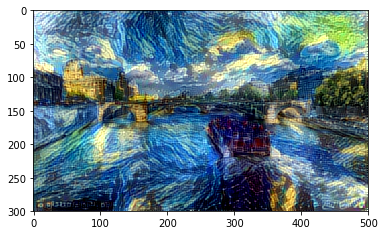

In [15]:
# 根据后端初始化一张噪声图片，做去均值
if K.image_dim_ordering() == 'th':
    x = np.random.uniform(0, 255, (1, 3, img_nrows, img_ncols)) - 128.
else:
    x = np.random.uniform(0, 255, (1, img_nrows, img_ncols, 3)) - 128. 

for i in range(30):
    print('Start of iteration', i)
    start_time = time.time()
    '''
    fmin_l_bfgs_b这个函数来自scipy.optimize, fmin代表它是一个用来最小化某个函数的优化器，l_bfgs_b代表它用的算法是L-BFGS-B
    这个函数的原型是：
       def fmin_l_bfgs_b(func, x0, fprime=None, args=(),
                  approx_grad=0,
                  bounds=None, m=10, factr=1e7, pgtol=1e-5,
                  epsilon=1e-8,
                  iprint=-1, maxfun=15000, maxiter=15000, disp=None,
                  callback=None, maxls=20):
    程序中设置了三个主要的参数：

    * func：这个是待优化的函数，也就是我们的目标函数
    * x0：初始值，也就是我们的初始图片
    * fprime：一个callable的函数，返回梯度，也就是K.grad求出来的玩意
    * maxfun：最大迭代次数，就是func要被迭代优化多少次   
    根据函数说明，func和fprime是返回标量值的callable对象(函数)，x0是个1D的nparray，fprime用来更新x，当然其返回值也是一个与x0同shape的1D的nparray
    '''
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20) 
    print('Current loss value:', min_val)
    # save current generated image
    # 每次迭代完成后把输出的图片后处理一下，保存起来
    img = deprocess_image(x.copy()) 
    fname = 'transfer_result' + '_at_iteration_%d.png' % i
    plt.imshow(img)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
print('Iteration %d completed in %ds' % (i, end_time - start_time))